## Finding realistic adversarial examples: white-box approach

This script takes as input a classifier and a generative model and looks for 4 realistic adversarial examples.
It is a white-box approach: the inner structure of the networks (weights in particular) is used to compute a gradient.

In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import time
%matplotlib inline

digit_origin = 8
digit_target = 3

classifier = tf.keras.models.load_model('Models/classifier_capacity1_simple.model', compile=True)
gan = tf.keras.models.load_model('Models/gan_digit8_rich.h5')

/home/mohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [2]:
classifier.trainable = False
combined_networkInput = tf.keras.layers.Input(shape=(10,))
x = (gan(combined_networkInput) + 1.0)/2.0
new_shape = tf.convert_to_tensor([1,28,28,1],dtype=tf.int32)
x = tf.reshape(x,new_shape,name=None)
combined_networkOutput = classifier(x)
combined_network = tf.keras.models.Model(inputs=combined_networkInput, outputs=combined_networkOutput)

try a new seed
confidence of 3 2.1585804e-12
confidence of 8 1.0
confidence of 3 2.8108944e-11
confidence of 8 1.0
confidence of 3 3.984875e-10
confidence of 8 0.9999999
confidence of 3 3.382273e-09
confidence of 8 0.9999989
confidence of 3 1.4455227e-08
confidence of 8 0.9999963
confidence of 3 4.2351502e-08
confidence of 8 0.99999106
confidence of 3 7.773666e-08
confidence of 8 0.9999876
confidence of 3 1.06161615e-07
confidence of 8 0.9999815
confidence of 3 1.1465483e-07
confidence of 8 0.9999683
confidence of 3 2.5491522e-07
confidence of 8 0.9999677
confidence of 3 6.229696e-07
confidence of 8 0.99993956
confidence of 3 1.1222165e-06
confidence of 8 0.9999219
confidence of 3 3.6911952e-06
confidence of 8 0.9997876
confidence of 3 6.1644964e-06
confidence of 8 0.99970347
confidence of 3 7.1996174e-06
confidence of 8 0.9996629
confidence of 3 7.4274444e-06
confidence of 8 0.99960023
confidence of 3 1.0262587e-05
confidence of 8 0.9993771
confidence of 3 1.0119953e-05
confidence of 

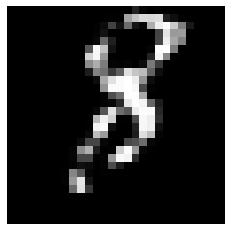

In [5]:
noise_change = 0.1

found = False

loss_object = tf.keras.losses.CategoricalCrossentropy()

input_label = np.zeros((1,10))
input_label[0][digit_target] = 0.7
input_label[0][digit_origin] = 0.3

start = time.time()

while(not found):
        noise = np.random.normal(0,1,size=[1,10])
        noise = tf.cast(noise,tf.float32)

        print("try a new seed")
        j = 0
        while(j < 25 and not found):
                prediction = combined_network(noise)
                loss = loss_object(input_label,prediction)
                grad = tf.gradients(loss,noise)[0]
                perturbations = tf.sign(grad)
                noise -= noise_change*perturbations
                result_target = K.eval(combined_network(noise))[0][3]
                print("confidence of 3",result_target)
                print("confidence of 8",K.eval(combined_network(noise))[0][8])
                if(result_target < 0.05 and K.eval(combined_network(noise))[0][8] < 0.05):
                      break
                if(result_target >= 0.5):
                      generated_image = K.eval(gan(noise))[0]
                      print("Confidence in %d is %f" % (digit_target,result_target))
                      plt.imshow(generated_image.reshape(1,28,28)[0],cmap='gray')
                      plt.axis("off")
                      found = True
                j += 1

end = time.time()
print("time: %f" % (end - start))

plt.savefig('adversarial_examples_white_box.png')
plt.show()